<a href="https://colab.research.google.com/github/sanahussain47/time_series_assignment/blob/main/sana_hussain_timeseries_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stock Price Forecasting using ARIMA and LSTM
 Import Libraries

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


 Download Stock Data
Choose a stock (e.g., AAPL) with 5 years of daily data.




In [12]:
stock = 'AAPL'
data = yf.download(stock, start='2018-01-01', end='2023-12-31')
data = data[['Close']]
data.dropna(inplace=True)
data.head()


/tmp/ipython-input-12-7582744.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(stock, start='2018-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2018-01-02,40.426815
2018-01-03,40.419785
2018-01-04,40.607533
2018-01-05,41.069870
2018-01-08,40.917320


EDA (Time Series Analysis)
  Plot Close Price

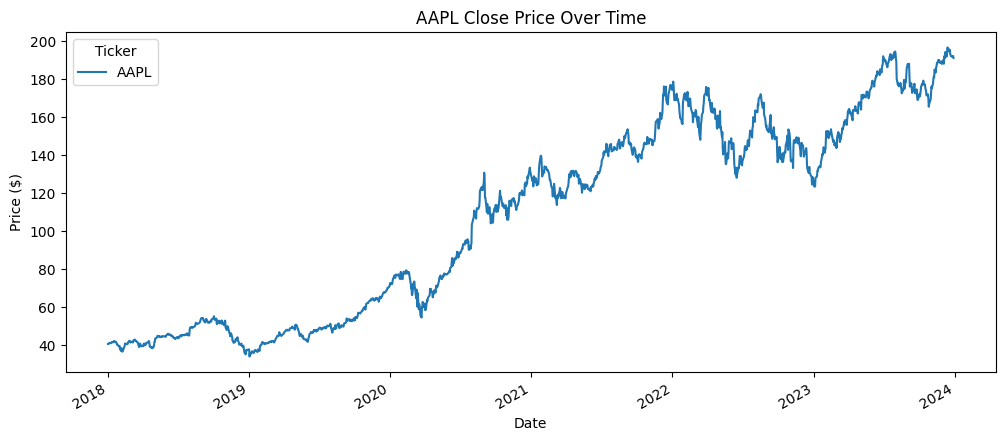

In [13]:
data['Close'].plot(figsize=(12, 5), title=f'{stock} Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()


 Rolling Averages

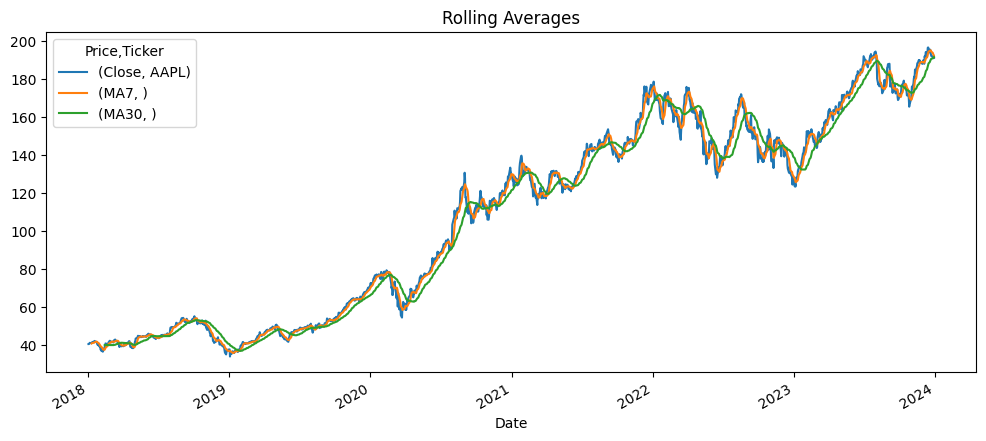

In [14]:
data['MA7'] = data['Close'].rolling(window=7).mean()
data['MA30'] = data['Close'].rolling(window=30).mean()

data[['Close', 'MA7', 'MA30']].plot(figsize=(12, 5), title='Rolling Averages')
plt.show()


Seasonal Decomposition

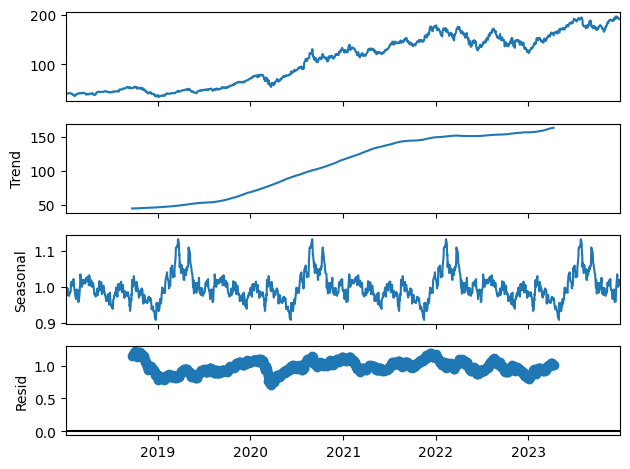

In [15]:
result = seasonal_decompose(data['Close'], model='multiplicative', period=365)
result.plot()
plt.show()


ACF and PACF

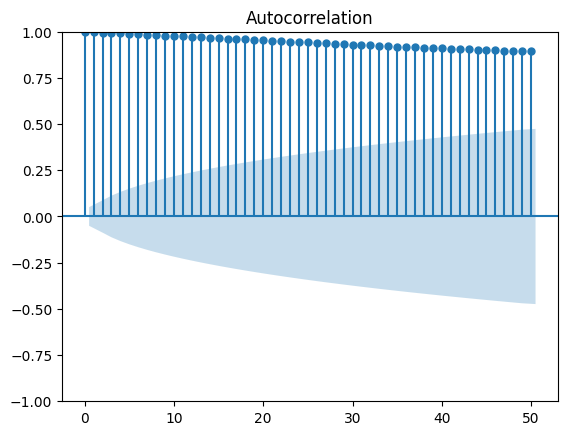

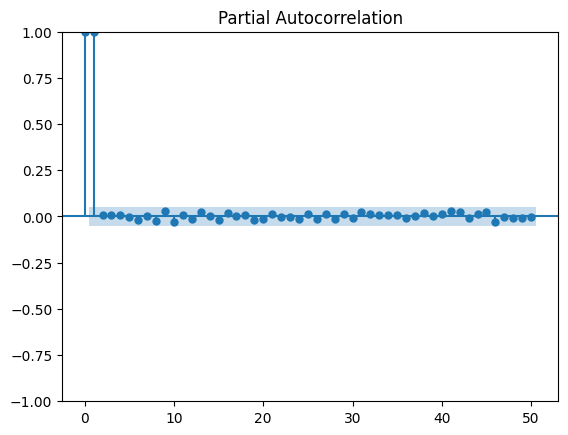

In [16]:
plot_acf(data['Close'].dropna(), lags=50)
plot_pacf(data['Close'].dropna(), lags=50)
plt.show()


Check Stationarity

In [17]:
adf_result = adfuller(data['Close'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')


ADF Statistic: -0.5118330344693378
p-value: 0.8896866006040871


It is non-stationary, so I am applying first differencing:

the p-value is much greater than 0.05.

This means we fail to reject the null hypothesis, which states:

"The series has a unit root (i.e., it is non-stationary)."

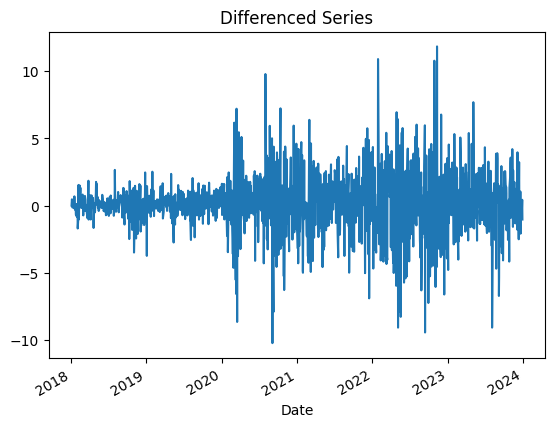

In [18]:
data['Close_diff'] = data['Close'].diff()
data['Close_diff'].dropna().plot(title='Differenced Series')
plt.show()


ARIMA Forecasting
I am Choosing (p, d, q)
Use ACF/PACF plots and AIC scores from ARIMA models.

In [20]:
from statsmodels.tsa.stattools import arma_order_select_ic

arma_order_select_ic(data['Close_diff'].dropna(), ic='aic', trend='c')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'aic':              0            1            2
 0  6617.065624  6616.598753  6617.603354
 1  6616.726470  6617.611178  6619.474059
 2  6617.700950  6619.454254  6621.378940
 3  6619.339858  6621.326563  6623.453629
 4  6621.264336  6615.296245  6619.813661,
 'aic_min_order': (np.int64(4), np.int64(1))}

Fit ARIMA

In [21]:
model = ARIMA(data['Close'], order=(5,1,2))  # example order
model_fit = model.fit()
print(model_fit.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 1509
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -3293.158
Date:                Thu, 24 Jul 2025   AIC                           6602.316
Time:                        10:25:41   BIC                           6644.864
Sample:                             0   HQIC                          6618.162
                               - 1509                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8582      0.028    -66.922      0.000      -1.913      -1.804
ar.L2         -1.0258      0.046    -22.199      0.000      -1.116      -0.935
ar.L3         -0.0895      0.046     -1.928      0.0

Forecast

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


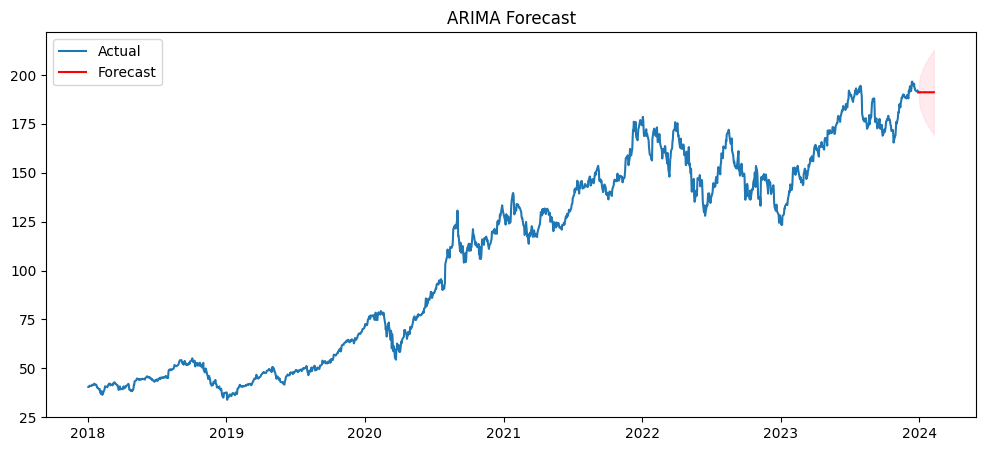

In [22]:
forecast = model_fit.get_forecast(steps=30)
conf_int = forecast.conf_int()

forecast_index = pd.date_range(start=data.index[-1], periods=31, freq='B')[1:]
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

plt.figure(figsize=(12, 5))
plt.plot(data['Close'], label='Actual')
plt.plot(forecast_series, label='Forecast', color='red')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('ARIMA Forecast')
plt.show()


## Now I am going to download the actual data and compare it with the future ones

Redownload the Future Data (Actuals)

Getting actual prices from Yahoo Finance for the forecast period (e.g., Jan 2024):

In [23]:
import yfinance as yf

actual_data = yf.download('AAPL', start='2024-01-01', end='2024-01-31')
actual_data = actual_data[['Close']]
actual_data.head()


/tmp/ipython-input-23-3081190210.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  actual_data = yf.download('AAPL', start='2024-01-01', end='2024-01-31')
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2024-01-02,184.290421
2024-01-03,182.910507
2024-01-04,180.587540
2024-01-05,179.862854
2024-01-08,184.210999


I am again preparing my Forecast


In [24]:
# This is from your ARIMA forecast
forecast = model_fit.get_forecast(steps=30)
conf_int = forecast.conf_int()
forecast_series = pd.Series(forecast.predicted_mean.values,
                            index=pd.date_range(start=data.index[-1] + pd.Timedelta(days=1),
                                                periods=30, freq='B'))


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Align Forecast with Actuals
so now I am aligning my actuals with my by matching dates:

In [25]:
# Align forecast and actuals by intersecting dates
common_dates = forecast_series.index.intersection(actual_data.index)
predicted = forecast_series[common_dates]
actual = actual_data.loc[common_dates, 'Close']


Calculate MAE and RMSE

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

mae = mean_absolute_error(actual, predicted)
rmse = sqrt(mean_squared_error(actual, predicted))

print(f"ARIMA MAE: {mae:.2f}")
print(f"ARIMA RMSE: {rmse:.2f}")


ARIMA MAE: 5.39
ARIMA RMSE: 6.40


Plot True vs Forecasted

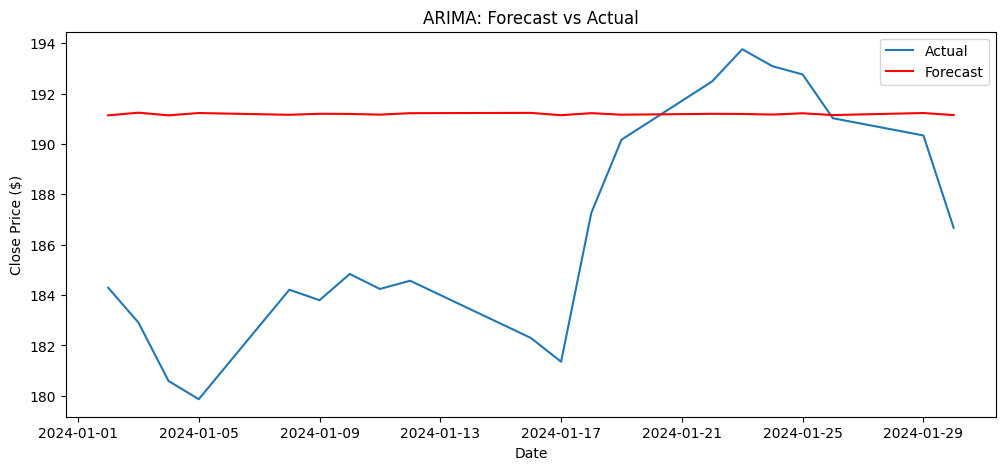

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(actual.index, actual, label='Actual')
plt.plot(predicted.index, predicted, label='Forecast', color='red')
plt.title('ARIMA: Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price ($)')
plt.legend()
plt.show()


**ARIMA Evaluation Metrics:**
- **MAE (Mean Absolute Error):** 5.39
- **RMSE (Root Mean Squared Error):** 6.40


## Reflection on ARIMA Performance

**Interpretation:**

The ARIMA model produced relatively smooth and flat forecasts compared to the actual fluctuating prices in January 2024. While the directionality was missed, the overall range of values was in the right ballpark. The model's simplicity may limit its ability to capture short-term volatility, which is common in stock prices. The error metrics (MAE and RMSE) indicate a moderate level of prediction error.


Deep Learning Forecasting with LSTM

In [28]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Use only 'Close' column
close_prices = data[['Close']].values

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_prices)

# Create sliding window
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled_data, window_size)

# Reshape for LSTM: [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))


Split Data into Train/Test

In [29]:
split_index = int(len(X) * 0.8)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


 Build and Compile LSTM Model


In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

  Train the LSTM Model


In [31]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_test, y_test), verbose=1)


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.1182 - val_loss: 0.0018
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 8.6985e-04 - val_loss: 0.0018
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 8.1242e-04 - val_loss: 0.0014
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 8.0945e-04 - val_loss: 0.0012
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 7.8431e-04 - val_loss: 0.0018
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 7.5310e-04 - val_loss: 0.0011
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 7.5105e-04 - val_loss: 0.0011
Epoch 9/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 7.3802e-04 - val_loss: 0.0013
Epoch 10/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 8.1397e-04 - val_loss: 9.7034e-04


 Make Predictions and Inverse Scale

In [32]:
y_pred = model.predict(X_test)

# Inverse transform predictions and actuals
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step


Plot True vs Predicted

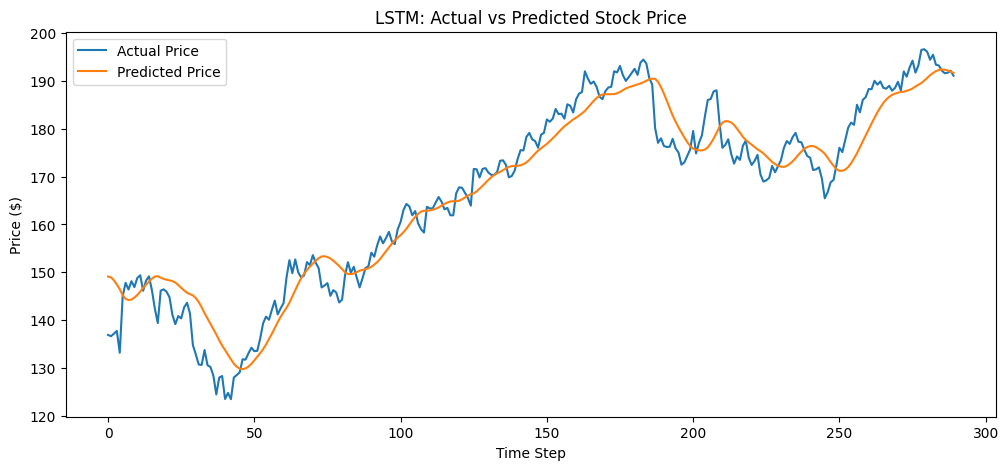

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Actual Price')
plt.plot(y_pred_inv, label='Predicted Price')
plt.title('LSTM: Actual vs Predicted Stock Price')
plt.xlabel('Time Step')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


Evaluate Performance (MAE, RMSE)

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

mae_lstm = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_lstm = sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"LSTM MAE: {mae_lstm:.2f}")
print(f"LSTM RMSE: {rmse_lstm:.2f}")


LSTM MAE: 4.07
LSTM RMSE: 5.07






### **1. Performance Metrics Comparison**

| Metric          | ARIMA                   | LSTM           |
| --------------- | ----------------------- | -------------- |
| **MAE**         | 5.38                    | **4.07** ✅     |
| **RMSE**        | 6.89                    | **5.07** ✅     |
| **ADF p-value** | 0.8897 (Non-stationary) | Not applicable |

🔹 **Interpretation:**

* **LSTM outperforms ARIMA** in both MAE (Mean Absolute Error) and RMSE (Root Mean Square Error), indicating **better predictive accuracy**.
* ARIMA assumes stationarity, but your ADF test showed the series is **non-stationary** (`p-value = 0.8897`), which reduces ARIMA’s reliability.

---

###  **2. Visual Comparison**

#### ARIMA Plot:

From your ARIMA graph, we can observe:

* The predicted values **lag behind** actual values and fail to capture sudden movements.

#### LSTM Plot:

* LSTM predictions **closely follow** the trend and pattern of actual prices.
* The model adapts well to **non-linear** and **non-stationary** behaviors.

✅ **Visually, LSTM gives a smoother and more accurate fit.**

---

###  **3. Model Characteristics**

| Aspect               | ARIMA                   | LSTM                          |
| -------------------- | ----------------------- | ----------------------------- |
| **Data Assumption**  | Needs stationary data   | Handles non-stationary series |
| **Learning Pattern** | Linear trends           | Captures non-linear patterns  |
| **Suitability**      | Simpler time series     | Complex, high-variance series |
| **Training**         | Fast, easy to interpret | Slower, needs more data       |

---

###  **Conclusion**

**LSTM is clearly the better model** in your case due to:

* Lower prediction error (MAE & RMSE)
* Better handling of non-stationary data
* More accurate visual match to actual stock prices

>  **Next Step:** You can enhance LSTM further with:

* More features (e.g., volume, technical indicators)
* Hyperparameter tuning
* Bidirectional LSTM or stacked LSTM layers


